# setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp
from tensorflow.keras import layers
from tensorflow import keras
import keras
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

2025-06-18 01:16:19.026320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750209379.222337 1563009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750209379.269116 1563009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750209379.757194 1563009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750209379.757212 1563009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750209379.757214 1563009 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [28]:
proj_name = 'updraft_coal_4ma_r2'
filename = proj_name + '_N10000_dt300.nc'

param_all_idx = np.arange(36)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
param_interest_idx = np.arange(16,26)
# param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))

param_train = ef.get_params(lp.nc_dir, filename, param_interest_idx)

In [29]:
nppe, npar = param_train['vals'].shape

In [30]:
dataset = nc.Dataset(lp.nc_dir + filename, mode='r')

In [31]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [32]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)
ncases = tgt_raw_vals[0].shape[0]
nvar = len(var_constraints)

In [33]:
var_constraints

['dn liq by coll', 'dmx liq by coll', 'dmy liq by coll']

In [34]:
from sklearn import preprocessing

ppe_var_presence = []
ppe_norm = []
ppe_data = []
tgt_var_presence = []
tgt_norm = []
tgt_data = []
standard_scales = []
minmaxscales = []

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

dmin = 0.
dmax = 9.2
drange = dmax - dmin


for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)

    ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
    tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

    if 'V_M' in var_constraints[idx]:
        mmscale = preprocessing.MinMaxScaler().fit(ppe_raw_val_reshaped)
        # manually set all minmaxscale to the same range
        mmscale.data_min_[:] = dmin
        mmscale.data_max_[:] = dmax
        mmscale.data_range_[:] = drange
        mmscale.scale_[:] = 1/drange
        minmaxscales.append(mmscale)
        ppe_data.append(mmscale.transform(ppe_raw_val_reshaped))
        tgt_data.append(mmscale.transform(tgt_raw_val_reshaped))
    else:
        ppe_norm.append(ef.smooth_linlog(ppe_raw_val_reshaped, eff0))
        tgt_norm.append(ef.smooth_linlog(tgt_raw_val_reshaped, eff0))    
        standscale = preprocessing.StandardScaler().fit(ppe_norm[-1])
        standard_scales.append(standscale)

        

mom_consistency_mask = np.min(np.array(ppe_var_presence), axis=0)
scale_mask = np.max(mom_consistency_mask, axis=0)

for i, iscale in enumerate(standard_scales):
    iscale.scale_ = iscale.scale_ * scale_mask
    dat = iscale.transform(ppe_norm[i])
    dat[np.isinf(dat)] = np.nan
    ppe_data.append(dat)
    dat = iscale.transform(tgt_norm[i])
    dat[np.isinf(dat)] = np.nan
    tgt_data.append(dat)

/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: invalid value encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:1085: RuntimeWarning: divide by zero encountered in divide
  X /= self.scale_
/global/homes/a/arthurhu/.conda/envs/BOSS_PPE/lib/python3.12/site-packages/sklearn

In [35]:
standard_scales

[StandardScaler(), StandardScaler(), StandardScaler()]

In [36]:
# from sklearn import preprocessing

# dmin = 0.
# dmax = 9.2
# drange = dmax - dmin

# ppe_var_presence = []
# ppe_data = []
# tgt_var_presence = []
# tgt_data = []
# standard_scales = []
# minmaxscales = []

# idx = 0
# eff0 = eff0s[idx]
# for idx, eff0 in enumerate(eff0s):
#     if ppe_raw_vals[idx].ndim >= 2:
#         ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
#         tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
#     else:
#         ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
#         tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)

#     ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
#     tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

#     # ppe_norm = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
#     # tgt_norm = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
#     # standscale = preprocessing.StandardScaler().fit(ppe_norm)
#     # standard_scales.append(standscale)
#     # ppe_data.append(standscale.transform(ppe_raw_val_reshaped))
#     # tgt_data.append(standscale.transform(tgt_raw_val_reshaped))
#     # TODO: set all mins to 0 and all maxes to 9.1
#     mmscale = preprocessing.MinMaxScaler().fit(ppe_raw_val_reshaped)
#     # manually set all minmaxscale to the same range
#     mmscale.data_min_[:] = dmin
#     mmscale.data_max_[:] = dmax
#     mmscale.data_range_[:] = drange
#     mmscale.scale_[:] = 1/drange
#     minmaxscales.append(mmscale)
#     ppe_data.append(mmscale.transform(ppe_raw_val_reshaped))
#     tgt_data.append(mmscale.transform(tgt_raw_val_reshaped))

In [37]:
import sklearn.model_selection as mod_sec
y_train_wpresence = []
y_train_rawv = []
y_val_wpresence = []
y_val_rawv = []

y_train_rawv_wnan = []
y_val_rawv_wnan = []

x_train, x_val, _, _ = mod_sec.train_test_split(x_all, ppe_var_presence[0], test_size=0.2, random_state=1)

for ivar, (ppe_varp, ppe_varr) in enumerate(zip(ppe_var_presence, ppe_data)):
    _, _, y_train_wpresence_single, y_val_wpresence_single = mod_sec.train_test_split(x_all, ppe_varp, test_size=0.2, random_state=1)
    _, _, y_train_rawv_single, y_val_rawv_single = mod_sec.train_test_split(x_all, ppe_varr, test_size=0.2, random_state=1)
    y_train_wpresence.append(y_train_wpresence_single)
    y_train_rawv.append(np.nan_to_num(y_train_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))
    y_train_rawv_wnan.append(y_train_rawv_single)
    y_val_wpresence.append(y_val_wpresence_single)
    y_val_rawv.append(np.nan_to_num(y_val_rawv_single, nan=-1001, neginf=-1001, posinf=-1001))
    y_val_rawv_wnan.append(y_val_rawv_single)


In [38]:
ppe_data[0].shape

(10000, 720)

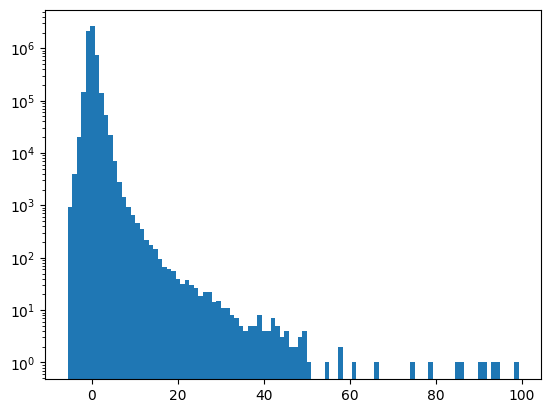

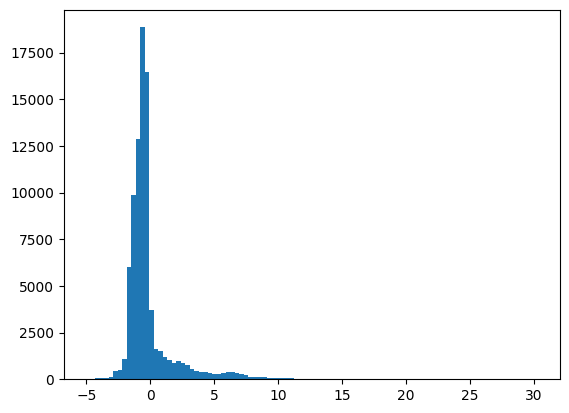

In [39]:
i=0
_ = plt.hist(ppe_data[i].flatten(), bins=100)
plt.yscale('log')
plt.figure()
_ = plt.hist(tgt_data[i].flatten(), bins=100)

## multi-head (implicit) model

In [40]:
# from tensorflow.keras.callbacks import TerminateOnNaN

# nobs = [i.shape[1] for i in ppe_var_presence]
# nvar = len(ppe_var_presence)

# proj_name = 'try10_updraft_coal_multihead_momrates'
# tuner = kt.RandomSearch(
#     lambda hp: tu.build_multihead_model(hp, npar, nvar, nobs),
#     objective="val_loss",
#     max_trials=50,
#     directory=lp.bossppe_dir+'/hp_tuning/multi-head',
#     project_name=proj_name,
# )

# stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
# tuner.search(
#     x_train,
#     y_train_rawv,
#     epochs=50,
#     validation_data=(x_val, y_val_rawv),
#     callbacks=([stop_early, TerminateOnNaN()])
# )

# # Retrieve the best hyperparameters and build the best model:
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hp)

In [41]:
# best_model.summary()
# # best_model.outputs

In [42]:
# stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1000)

# # y_train_list = y_train_wpresence + y_train_rawv
# # y_val_list   = y_val_wpresence   + y_val_rawv

# history = best_model.fit(
#     x=x_train,
#     y=y_train_rawv,
#     epochs=10000,
#     verbose=0,
#     validation_data=(x_val, y_val_rawv),
#     callbacks=[TqdmCallback(verbose=1), stop_early]
# )


In [43]:
# # plt.figure()
# # plt.plot(history.epoch, history.history['presence_loss'], label='Training')
# # plt.plot(history.epoch, history.history['val_presence_loss'], label='Validation')
# # plt.ylabel('Water Presence Loss')
# # plt.legend()

# plt.figure()
# plt.plot(history.epoch, history.history['loss'], label='Training')
# plt.plot(history.epoch, history.history['val_loss'], label='Validation')
# plt.ylabel('Loss')
# plt.legend()

In [44]:
# # save model:
# best_model.save(lp.bossppe_dir + '/models/multioutput_' + proj_name + '.keras')

## multi-output (explicit) model

In [45]:
from tensorflow.keras.callbacks import TerminateOnNaN

nobs = [i.shape[1] for i in ppe_var_presence]
nvar = len(ppe_var_presence)

tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nvar, nobs),
    objective="val_loss",
    max_trials=35,
    directory=lp.bossppe_dir+'/hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train_rawv},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val_rawv}),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 35 Complete [00h 00m 32s]
val_loss: 0.1833421140909195

Best val_loss So Far: 0.14943498373031616
Total elapsed time: 00h 18m 38s


In [46]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 96)        │      1,248 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 192)       │     18,624 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 192)       │     37,056 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 160)       │     30,880 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 192)       │     30,912 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_0 (Dense)  │ (None, 720)       │    138,960 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_1 (Dense)  │ (None, 720)       │    138,960 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_2 (Dense)  │ (None, 720)       │    138,960 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_0 (Dense)     │ (None, 720)       │    138,960 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_1 (Dense)     │ (None, 720)       │    138,960 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water_2 (Dense)     │ (None, 720)       │    138,960 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 952,480 (3.63 MB)

 Trainable params: 952,480 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

y_train_list = y_train_wpresence + y_train_rawv
y_val_list   = y_val_wpresence   + y_val_rawv

history = best_model.fit(
    x=x_train,
    y=y_train_list,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val_list),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

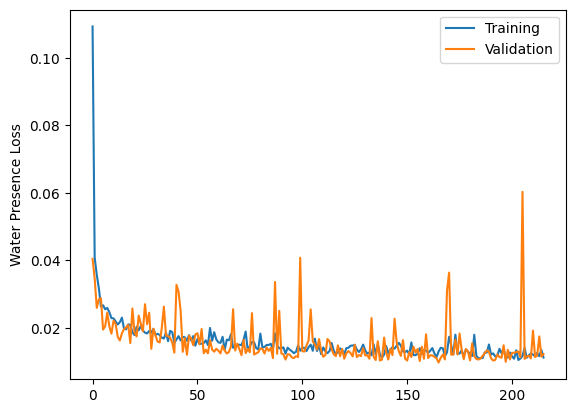

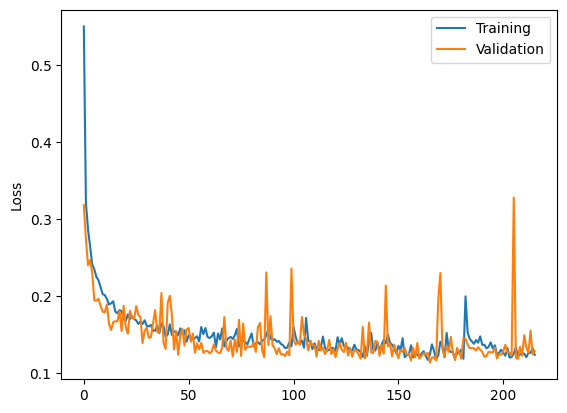

In [48]:
plt.figure()
plt.plot(history.epoch, history.history['presence_loss'], label='Training')
plt.plot(history.epoch, history.history['val_presence_loss'], label='Validation')
plt.ylabel('Water Presence Loss')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

In [49]:
# save model:
best_model.save(lp.bossppe_dir + '/models/multioutput_' + proj_name + '.keras')

## validation

In [50]:
# proj_name = 'rainshaft_V_and_moments'
# best_model = tf.keras.models.load_model('models/multioutput_' + proj_name + '.keras', compile=False)

In [51]:
# var_len = [int(np.prod(ppe_raw_vals[i].shape[1:])) for i in range(len(ppe_raw_vals))]
# itr = list([np.arange(0, var_len[0])])
# for ivlen, vlen in enumerate(var_len[1:]):
#     itr.append(np.arange(itr[ivlen][-1]+1, itr[ivlen][-1]+1+vlen))
y_pred_inv = []
y_val_lin_inv = []
y_pred = []
y_val_lin = []

# for i in range(nvar):
#     y_pred_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(best_model(x_val)[i].numpy().astype('float64')),eff0s[i]))
#     y_val_lin_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(y_val_rawv[i].astype('float64')),eff0s[i]))
#     y_pred.append(best_model(x_val)[i].numpy().astype('float64'))
#     y_val_lin.append(y_val_rawv[i].astype('float64'))

for i in range(nvar):
    presence = best_model(x_val)['presence'][i].numpy()
    # presence[presence<0.1] = 0.
    if 'V_M' in var_constraints[idx]:
        y_pred_inv.append(presence * minmaxscales[i].inverse_transform(best_model(x_val)['water'][i].numpy().astype('float64')))
        y_val_lin_inv.append(minmaxscales[i].inverse_transform(y_val_rawv[i].astype('float64')))
    else:
        y_pred_inv.append(presence * ef.inv_smooth_linlog(standard_scales[i].inverse_transform(best_model(x_val)['water'][i].numpy().astype('float64')),eff0s[i]))
        y_val_lin_inv.append(ef.inv_smooth_linlog(standard_scales[i].inverse_transform(y_val_rawv[i].astype('float64')),eff0s[i]))
        
    y_pred.append(best_model(x_val)['water'][i].numpy().astype('float64'))
    y_val_lin.append(y_val_rawv[i].astype('float64'))
    

for ivar in y_val_lin:
    ivar[ivar<-999] = np.nan

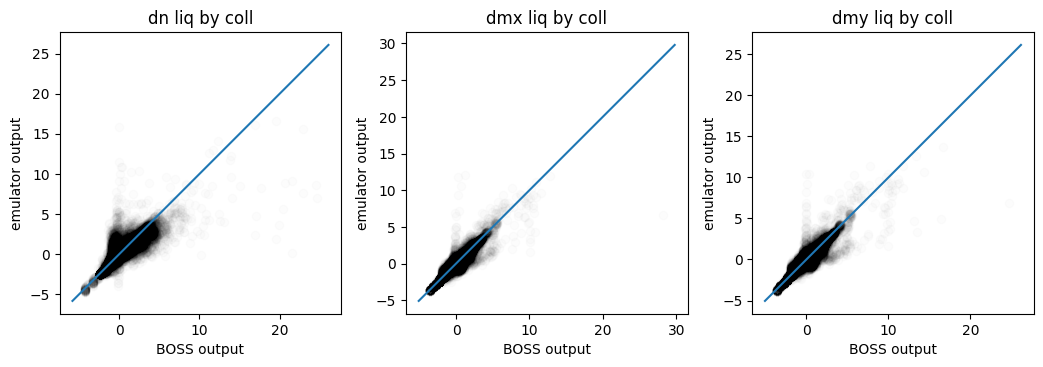

In [52]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(2,4)
ivar = 0
for i in range(len(eff0s)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    vlen = y_val_lin[i].size
    alpha = max(1/np.sqrt(vlen), 0.01)
    plt.scatter(y_val_lin[i].flatten()[::10], y_pred[i].flatten()[::10], alpha=alpha, c='k')
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    plt.title(var_constraints[i])
    plt.xlabel('BOSS output')
    plt.ylabel('emulator output')
fig.tight_layout()
plt.savefig('plots/' + proj_name + '.png')

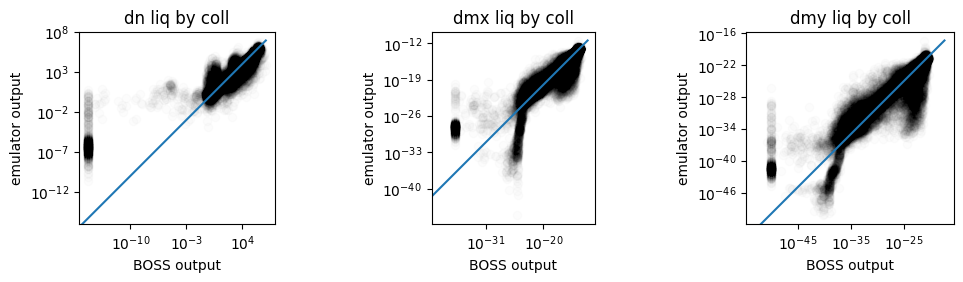

In [53]:
fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(2,4)
ivar = 0
for i in range(len(eff0s)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    vlen = y_val_lin[i].size
    alpha = max(1/np.sqrt(vlen), 0.01)
    plt.scatter(y_val_lin_inv[i].flatten()[::10], y_pred_inv[i].flatten()[::10], alpha=alpha, c='k')
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    plt.title(var_constraints[i])
    plt.xlabel('BOSS output')
    plt.ylabel('emulator output')
    # if i>3:
    plt.xscale('log')
    plt.yscale('log')
fig.tight_layout()
plt.savefig('plots/' + proj_name + '_inv.png')